In [726]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.spatial.distance import cdist
import scipy.stats
import copy
import math
from scipy.integrate import quad

### Question 1  
**Write a program to implement a region segmentation algorithm using the fuzzy c-means algorithm on normalized 'RGBxy' data of an image. Merge stray (isolated) pixels (or very-smallregions) to their surrounding regions. [3 marks]**


In [2]:
img = cv2.imread("house21.jpg")
img = Image.open("house21.jpg")

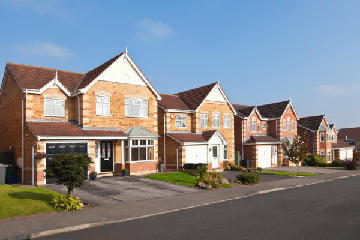

In [3]:
width, height = img.size 
newsize = (int(width*0.6), int(height*0.6))
img = img.resize(newsize)
display(img)

In [4]:
img = np.array(img)
img_data = np.zeros((img.shape[0], img.shape[1], 5))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_data[i,j,0:3] = img[i,j]/255
        img_data[i,j,3] = i/img.shape[0]
        img_data[i,j,4] =  j/img.shape[1]
img_data = img_data.reshape(((img.shape[0]*img.shape[1], 5))).T
print(img_data.shape)

(5, 86400)


In [5]:
fcm = fuzz.cluster.cmeans(img_data, 25, 2, error=0.05, maxiter=1000, init=None)

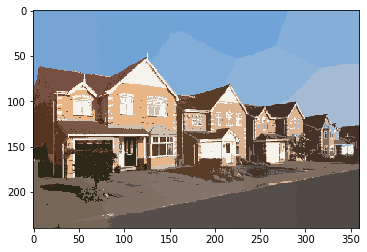

In [6]:
cluster_centers = fcm[0]
prob_matrix = fcm[1]
pred_matrix = np.argmax(prob_matrix, axis = 0)
pred_matrix = cluster_centers[pred_matrix]
clustered_image = pred_matrix[:,0:3]
clustered_image = clustered_image.reshape(((img.shape[0],img.shape[1], 3)))*255
clustered_image = clustered_image.astype(int)
plt.imshow(clustered_image)

### Question 2
**Write a program to obtain the spatial and contrast cues using SLIC superpixels of an image instead of pixels. [3 marks]**

(256, 256, 3)


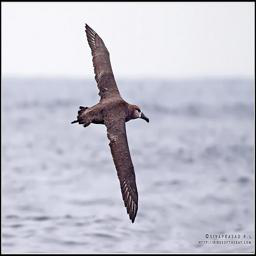

In [696]:
img_path = 'Black_Footed_Albatross_0009_34.jpg'

image  = cv2.imread(img_path)
# plt.imshow(image)
print(image.shape)
display(Image.open(img_path))

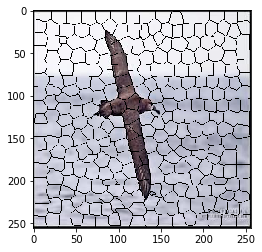

In [697]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Initialize the slic item, the average size of super pixels is 20 (default is 10), and the smoothing factor is 20
slic = cv2.ximgproc.createSuperpixelSLIC(img,region_size=15,ruler = 20.0) 
slic.iterate(40)     #Number of iterations, the greater the better
mask_slic = slic.getLabelContourMask() #Get Mask, Super pixel edge Mask==1
label_slic = slic.getLabels()        #Get superpixel tags
number_slic = slic.getNumberOfSuperpixels()  #Get the number of super pixels
mask_inv_slic = cv2.bitwise_not(mask_slic)  
img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic) #Draw the superpixel boundary on the original image
cv2.imshow("img_slic",img_slic)
plt.imshow(img_slic)


In [698]:
label_slic

array([[  1,   1,   1, ...,  16,  16,  16],
       [  1,   1,   1, ...,  16,  16,  16],
       [  1,   1,   1, ...,  16,  16,  16],
       ...,
       [272, 272, 272, ..., 288, 288, 288],
       [272, 272, 272, ..., 288, 288, 288],
       [272, 272, 272, ..., 288, 288, 288]], dtype=int32)

In [699]:
def get_super_image(image, segments):
    
    m,n = segments.shape
    
    dict_ = {}
    centers = {}

    for i in range(m):
        for j in range(n):
            if(segments[i,j] not in dict_):
                dict_[segments[i,j]] = []
                centers[segments[i,j]] = []
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
            else :
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
    for key in list(dict_.keys()):
        dict_[key] = np.mean(np.array(dict_[key]), 0).astype(int)
        centers[key] = np.mean(np.array(centers[key]), 0).astype(int)
            
    slic_image = np.zeros((image.shape[0],image.shape[1],3))
    
    for i in range(m):
        for j in range(n):
            slic_image[i,j] =  dict_[segments[i,j]]
    slic_image = slic_image.astype(int)
    
#     print(slic_image)
    plt.imshow(slic_image)
    plt.title("SLIC Image")
    
    return slic_image, dict_, centers

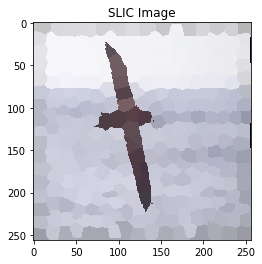

In [700]:
slic_image, dict_pixels, dict_centers = get_super_image(img,label_slic)

![title](contrast_cue_formula.PNG)
![title](spatial_cue_formula.PNG)



In [701]:
def contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers, k = 10):
    m,n = label_slic.shape
    
    data = np.zeros((len(list(dict_pixels.keys())), 3))
    l = sorted(list(dict_pixels.keys()))
    for i in range(len(l)):
        data[i] = dict_pixels[l[i]]
    
    print(data.shape)
    data = np.float32(data)/255
    
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(data, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

    pred_matrix = np.squeeze(labels)
    cluster_dist = cdist(centers,centers, 'euclidean')
    clustered_img = pred_matrix[label_slic]

    n_i = {}
    for i in np.unique(clustered_img):
        n_i[i] = np.count_nonzero(clustered_img == i)
    print(n_i)
    
    contrast_cues = {}
    for i in range(k):
        val = 0
        for j in range(k):
            if(i!=j):
                val+=(n_i[j]/(clustered_img.shape[0]*clustered_img.shape[1]))*cluster_dist[i,j]
        contrast_cues[i] = val
    print("\033[1mContrast Cues : \033[0m",contrast_cues)
    
    
    center_data = np.zeros((len(list(dict_centers.keys())), 2))
    l = sorted(list(dict_centers.keys()))
    for i in range(len(l)):
        a,b = dict_centers[l[i]]
        center_data[i,0] = a
        center_data[i,1] = b
    slic_image_center = dict_centers[label_slic[m//2,n//2]].reshape((1,2))
    slic_image_center[0,0] = slic_image_center[0,0]
    slic_image_center[0,1] = slic_image_center[0,1]
    slic_center_dist = cdist(center_data,slic_image_center,'euclidean')
    slic_center_dist_var = np.var(slic_center_dist)
#     print(slic_center_dist)
    
    spatail_cues = {}
    for c in range(k):
        val = 0
        for i in range(len(slic_center_dist)):
            if(pred_matrix[i] == c):
                val+=scipy.stats.norm(0, slic_center_dist_var).pdf(slic_center_dist[i,0])
        val = val/np.count_nonzero(pred_matrix == c)
        spatail_cues[c] = val
    
                
    print("\033[1mSpatial Cues : \033[0m",spatail_cues) 
    
    final_image = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            idx = clustered_img[i,j]
            val = spatail_cues[idx]*contrast_cues[idx]
            
            final_image[i,j] = val
    
    plt.imshow(final_image, cmap = 'gray')
    plt.title("Contrast and Spatial Cues of SLIC Image")
    return contrast_cues, spatail_cues,clustered_img, final_image
      
    

(289, 3)
{0: 2128, 1: 2121, 2: 520, 3: 1094, 4: 690, 5: 2610, 6: 59, 7: 1760, 8: 17839, 9: 2076, 10: 1754, 11: 4089, 12: 11731, 13: 7875, 14: 9190}
Contrast Cues :  {0: 0.319367335114446, 1: 0.2718677239891505, 2: 0.24802213004180446, 3: 0.25932155395534734, 4: 0.22279541936954034, 5: 0.24955207303088164, 6: 1.3233292345514238, 7: 0.21067713007624664, 8: 0.1615075375981102, 9: 0.18868829545884758, 10: 0.22325706378515786, 11: 0.8281133433646537, 12: 0.2945203554019822, 13: 0.17540177394855225, 14: 0.18740705415649062}
Spatial Cues :  {0: 0.00030074428183351603, 1: 0.0003006896534440989, 2: 0.0003001768078380665, 3: 0.00030144722654633626, 4: 0.00030054735658621365, 5: 0.0003008056015162694, 6: 0.00030055587130579703, 7: 0.00030094719925091474, 8: 0.0003015206249442196, 9: 0.00030060335254455326, 10: 0.0003014347629214616, 11: 0.00030198690530680935, 12: 0.000301274614053111, 13: 0.00030144224628301315, 14: 0.00030128548354650393}


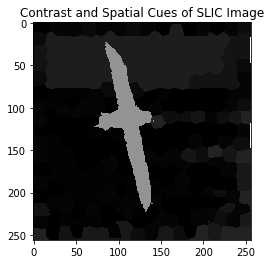

In [702]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers, 15)

### Question 3 
**Implement the separation measure discussed in Sec III.B.1 of the following paper to obtain 
quality scores for the two cues obtained in Q2. Use these quality scores as weights while 
performing the weighted sum of the two cues for getting the final saliency cue. [4 marks]**


In [703]:
def otsu(img):

    min_cost = float('inf')
    threshold = 0

    for i in range(1,256):
        v0 = np.var(img[img < i], ddof = 1)
        w0 = len(img[img < i])
        v1 = np.var(img[img >= i], ddof = 1)
        w1 = len(img[img >= i])

        cost = w0*v0 + w1*v1
        if(cost < min_cost):
            min_cost = cost
            threshold = i

    return threshold

(289, 3)
{0: 1807, 1: 3168, 2: 2033, 3: 448, 4: 22390, 5: 13975, 6: 231, 7: 255, 8: 59, 9: 983, 10: 921, 11: 4681, 12: 4886, 13: 5339, 14: 4360}
Contrast Cues :  {0: 0.32620333228591436, 1: 0.8697205224391031, 2: 0.26122632249069283, 3: 0.23772519930151714, 4: 0.15819154187478437, 5: 0.1871293465037991, 6: 0.23336126187903117, 7: 0.23207328381111153, 8: 1.323341754907355, 9: 0.21651395741860577, 10: 0.701637204259214, 11: 0.3072466310598246, 12: 0.28361808709756137, 13: 0.28539469561581876, 14: 0.19002781402994642}
Spatial Cues :  {0: 0.0003007553719535011, 1: 0.00030203003371784547, 2: 0.00030094933242573403, 3: 0.0003001322713522409, 4: 0.0003014803573155869, 5: 0.00030127494380087505, 6: 0.00030110348619418706, 7: 0.00030038467297640274, 8: 0.00030055587130579703, 9: 0.0003007355162720699, 10: 0.0003018359558681829, 11: 0.0003013560983325152, 12: 0.0003014231454906202, 13: 0.0003008043676891471, 14: 0.0003011986930749948}


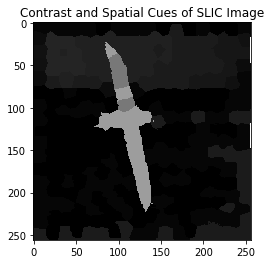

In [709]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers, 15)

Text(0.5, 1.0, 'Contrast Cue Image')

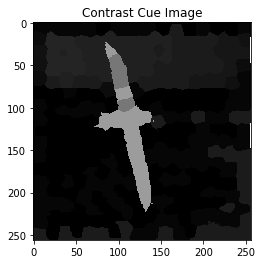

In [717]:
m,n = clustered_img.shape
contrast_cue_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        contrast_cue_image[i,j] = contrast_cues[clustered_img[i,j]]
plt.imshow(contrast_cue_image, cmap = 'gray')
plt.title("Contrast Cue Image")
        

Text(0.5, 1.0, 'Spatial Cue Image')

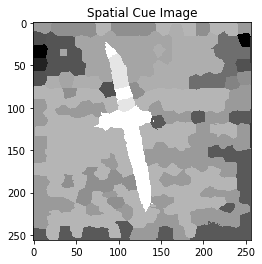

In [718]:
m,n = clustered_img.shape
spatial_cue_image = np.zeros((m,n))
for i in range(m):
        spatial_cue_image[i,j] = spatail_cues[clustered_img[i,j]]
plt.imshow(spatial_cue_image, cmap = 'gray')
plt.title("Spatial Cue Image")

#### Separation  Measure

In [725]:
def gaussian_distribution(x, mu, sigma):
    return (1/(sigma*math.sqrt(2*math.pi)))*np.exp(-(x/sigma - mu/sigma)**2)

In [732]:
def separation_Measure(saliency_map):
    saliency_map = (saliency_map/np.max(saliency_map))*255
    thres = otsu(saliency_map.astype(int))
    print("OTSU Threshold :", thres)
    mask = copy.deepcopy(saliency_map)
    mask[mask < thres] = 0
    mask[mask >= thres] = 1
    foreground_mask = mask
    background_mask = 1 - foreground_mask
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_mask, cmap = 'gray')
    plt.title("OTSU Foreground Threshold Mask")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_mask, cmap = 'gray')
    plt.title("OTSU Background Threshold Mask")
    plt.show()
    
    foreground_map = saliency_map*foreground_mask
    background_map = saliency_map*background_mask
    foreground_map = foreground_map/np.max(foreground_map)
    background_map = background_map/np.max(background_map)
    
    
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_map)
    plt.title(" Foreground  Map")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_map)
    plt.title(" Background  Map")
    plt.show()
    
    mu_f = np.mean(foreground_map[foreground_map > 0])
    sigma_f = np.std(foreground_map[foreground_map > 0])
    mu_b = np.mean(background_map[background_map > 0])
    sigma_b = np.std(background_map[background_map > 0])
    print("foreground mean , mu_f : ", mu_f)
    print("background mean , mu_b : ", mu_b)
    print("foreground  standard  deviation , sigma_f : ", sigma_f)
    print("background standard  deviation , sigma_b : ", sigma_b)
    
    fg_vals = foreground_map[foreground_map > 0].flatten()
    bg_vals = background_map[background_map > 0].flatten()
    fg_dist = scipy.stats.norm(mu_f, sigma_f**2).pdf(fg_vals)
    bg_dist = scipy.stats.norm(mu_b, sigma_b**2).pdf(bg_vals)
    
    z_star = (mu_b*sigma_f**2 - mu_f*sigma_b**2)/(sigma_f**2 - sigma_b**2)  +  (sigma_f*sigma_b/(sigma_f**2 - sigma_b**2))*((mu_f - mu_b)**2 - 2*(sigma_f**2 - sigma_b**2)*(math.log(sigma_b) - math.log(sigma_f)))**0.5
    print("z_star : ", z_star)
    L_s = quad(gaussian_distribution, 0, z_star, args=(mu_f,sigma_f))[0] + quad(gaussian_distribution, z_star, 1, args=(mu_b,sigma_b))[0]
    print("L_s : ", L_s)
    
    return L_s


    

For Contrast Cue 
  
OTSU Threshold : 63


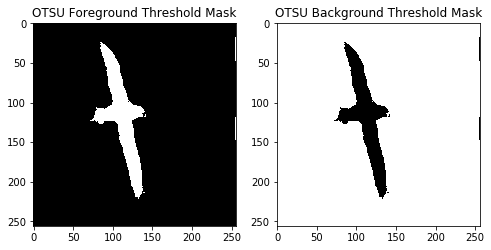

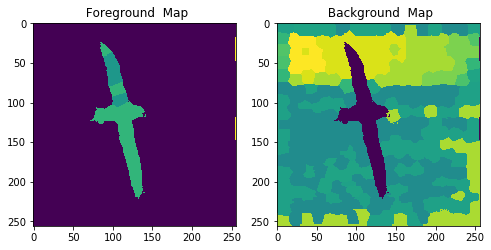

foreground mean , mu_f :  0.633889446940484
background mean , mu_b :  0.6435068777359022
foreground  standard  deviation , sigma_f :  0.06862369917267432
background standard  deviation , sigma_b :  0.17524710962178075
z_star :  0.5299255920748424
L_s :  0.5900004616359287
For Spatial Cue 
  
OTSU Threshold : 254


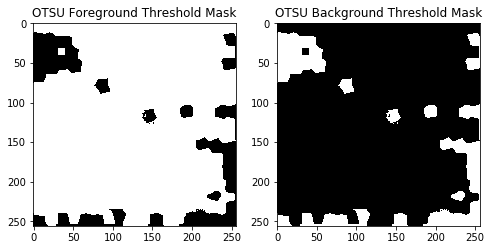

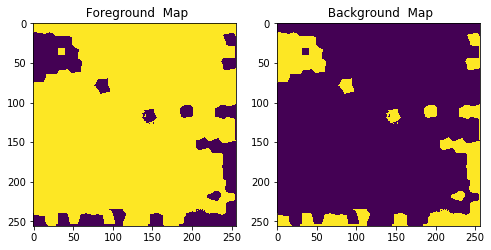

foreground mean , mu_f :  0.9979428885793821
background mean , mu_b :  0.9997835074572188
foreground  standard  deviation , sigma_f :  0.0006833459118657533
background standard  deviation , sigma_b :  0.0005255716821553257
z_star :  1.0059657586620954
L_s :  0.5090451823576355


In [733]:
print('\033[1mFor Contrast Cue \n  \033[0m')
sm_1 = separation_Measure(contrast_cue_image)

print('\033[1mFor Spatial Cue \n  \033[0m')
sm_2 = separation_Measure(spatial_cue_image)

Text(0.5, 1.0, 'Final Saliency Image')

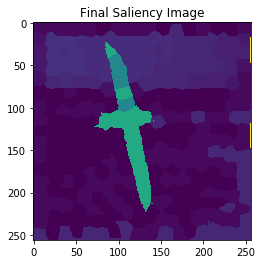

In [735]:
final_saliency_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        final_saliency_image[i,j] = sm_1*contrast_cues[clustered_img[i,j]] + sm_2*spatail_cues[clustered_img[i,j]]
plt.imshow(final_saliency_image)
plt.title("Final Saliency Image")

In [722]:
math.log(10)

2.302585092994046